# Getting Started

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [22]:
image_dir = Path('../input/cat-and-dog-images-dataset/Dog and Cat .png')

# Create File DataFrame

In [23]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [24]:
image_df

,Filepath,Label
0,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
1,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
2,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
3,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
4,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
...,...,...
994,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
995,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
996,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
997,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat


In [25]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Load Image Data

In [26]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [27]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Training

In [28]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 10s 553ms/step - loss: 0.6959 - accuracy: 0.4889 - val_loss: 0.6920 - val_accuracy: 0.4820
Epoch 2/100
18/18 [==============================] - 10s 525ms/step - loss: 0.6920 - accuracy: 0.5279 - val_loss: 0.6895 - val_accuracy: 0.4892
Epoch 3/100
18/18 [==============================] - 10s 573ms/step - loss: 0.6867 - accuracy: 0.5443 - val_loss: 0.6914 - val_accuracy: 0.5180
Epoch 4/100
18/18 [==============================] - 10s 555ms/step - loss: 0.6820 - accuracy: 0.5782 - val_loss: 0.6845 - val_accuracy: 0.5612
Epoch 5/100
18/18 [==============================] - 10s 564ms/step - loss: 0.6804 - accuracy: 0.5708 - val_loss: 0.6716 - val_accuracy: 0.6043
Epoch 6/100
18/18 [==============================] - 10s 558ms/step - loss: 0.6618 - accuracy: 0.6318 - val_loss: 0.6778 - val_accuracy: 0.5396
Epoch 7/100
18/18 [==============================] - 10s 533ms/step - loss: 0.6620 - accuracy: 0.6021 - val_loss: 0.6573 - val_accuracy:

# Results

In [29]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.65543
Test Accuracy: 62.67%


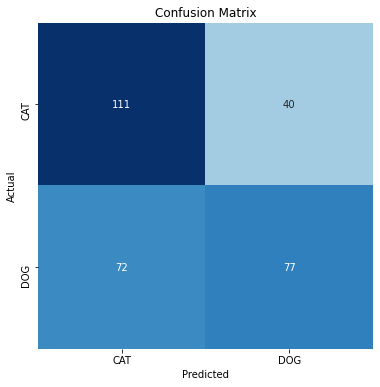

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.61      0.74      0.66       151
         DOG       0.66      0.52      0.58       149

    accuracy                           0.63       300
   macro avg       0.63      0.63      0.62       300
weighted avg       0.63      0.63      0.62       300



In [30]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)